## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

** (Semester 2, 2018) **

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset. 
    - Extended YaleB dataset. 
    - AR dataset (**optional**).
+ Perform Evaluation. 
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

Tutors: Fengxiang He, Nicholas James, Liu Liu, Zhuozhuo Tu, Baosheng Yu.

** Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html). **

## 1. Load Dataset

### 1.0 Data Folder

In [1]:
# The structure of data folder.
!ls -l data

total 0
drwxrwxrwx@ 41 heyujun  staff  1312 31 Aug 17:47 CroppedYaleB
drwx------@ 44 heyujun  staff  1408 31 Aug 17:47 ORL


## Tree structure of data folder

```
├── CroppedAR
    ├── M-001-01.bmp
    ├── M-001-01.txt
    ├── M-001-02.bmp
    ├── M-001-02.txt
    ├── ...
├── CroppedYaleB
│   ├── yaleB01
│   ├── yaleB02
│   ├── ...
│   ├── yaleB38
│   └── yaleB39
└── ORL
    ├── s1
    ├── s2
    ├── s3
    ├── ...
    ├── s40
```

### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [2]:
import os
import numpy as np
from PIL import Image

def load_data(root='data/CroppedYaleB', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):   
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):          
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm') or not fname.endswith('.pgm'):
                continue

            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.
            
            

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [3]:
# Load ORL dataset.
X_ORL, Y_ORL = load_data(root='data/ORL', reduce=2)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X_ORL.shape, Y_ORL.shape))

# Load Extended YaleB dataset.
X_Ya, Y_Ya = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YaleB dataset: X.shape = {}, Y.shape = {}'.format(X_Ya.shape, Y_Ya.shape))

ORL dataset: X.shape = (2576, 400), Y.shape = (400,)
Extended YaleB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


In [3]:
def norm(x):
    return (x-x.min())/(x.max()-x.min())

# NMF - algorithm 1

\begin{equation}
    \min_{D \in D, R \in R}{\| X - DR \|}^2_F
\end{equation}

In [4]:
# Const numbers
_largenumber = 1E100
_smallnumber = 1E-6

In [5]:
from numpy import linalg

def cost(X,D,R):
    """
    X -- m x n matrix, the input data set
    D -- m x k matrix
    R -- k x n matrix
    """
    c = X - np.dot(D,R)
    return linalg.norm(c) # I use 2-norm here
    #v = np.ones(X.shape)
    #c_2 = np.einsum('ij,ij', v*c, c)/np.count_nonzero(v)
    #return c_2


def optimiser(R, P, Q, max_iters = 5000):
    #Q = Q.T
    P = np.copy(P)
    Q = np.copy(Q)
    old_c = _largenumber
    
    c = cost(R, P, Q)
    
    i = 0
    #for i in range(num_iter):
    while (i < max_iters) and ((old_c-c)/old_c > _smallnumber):
        Pu = P*(R.dot(Q.T))/(P.dot(Q).dot(Q.T))
        Qu = Q*(Pu.T.dot(R))/(Pu.T.dot(Pu).dot(Q))
        
        old_c = c
        c = cost(R, Pu, Qu)
        if i%500==0:
            print(i, c)
        P = Pu
        Q = Qu
        i += 1
    print('Stop:', i, c)
    return P, Q

In [6]:
def NMF_base_fit(X,k=40,n_iter = 2000):  
    #import matplotlib.pyplot as plt
    R = X
    #N = len(R)
    #M = len(R[0])
    M = R.shape[0]   # rows
    N = R.shape[1]   # columns
    #K = 2
    K = k
    rng = np.random.RandomState(1)
    #P = rng.rand(N,K)
    #Q = rng.rand(M,K)
    P = rng.rand(M,K)
    Q = rng.rand(K,N)

    P_estimate, Q_estimate = optimiser(R,P,Q,n_iter)
    
    return P_estimate, Q_estimate
    #print(P_estimate.dot(Q_estimate.T))

In [7]:
# Compute re-construction error
#R - P_estimate.dot(Q_estimate.T)

# NMF - algorithm 2
**Can change the cost function which more robust to the noise** 

**$ L_{2,1}$ NMF **

The error function:
$$\| X-FG\|_{2,1} = \sum_{i=1}^{n}\|x_{i} - Fg_{i}\|_{2}$$

Objective function:
$$\min_{F,G}{\| X - FG \|_{2,1}}, s.t. F\geq0, G\geq0$$

our objective will minimize  $$ \sum_{i=1}^{n} \|x_{i} − Fg_{i} \|_{2} $$

Update rule:
$$F_{jk} \leftarrow F_{jk}\frac{(XDG^T)_{jk}}{(FGDG^T)_{jk}}$$
$$G_{ki} \leftarrow G_{ki}\frac{(F^{T}XD)_{ki}}{(F^{T}FGD)_{ki}}$$

D is a matrix with diagnal elements:
$$D_{ii} = \frac{1}{\| {X_{i} - Fg_i} \|}$$

Dimension check:

F: [M,K] 

G: [K,N]

X: [M,N]

D: [N,N]


In [8]:
from numpy import linalg


def L_21_cost(X,F,G):
    """
        g_i is the  i-th column of G
    """
    p = X.shape[0]
    n = X.shape[1]
    cost = np.sum([linalg.norm(X[:,i] - np.dot(F,G[:,i]), ord = 2) for i in range(n)])
    
    return np.sum(cost)
    

In [9]:
# Test cost function
np.random.seed(1234)
j,i = 5,4 # dim of features * number of obs
k=3
A = np.random.rand(j,i) # 5,4
F = np.random.rand(j,k) # 5,3
G = np.random.rand(k,i) # 3,4

L_21_cost(A,F,G)
#cost(A,F,G)

4.451826605207731

In [10]:
def compute_D(X,F,G):
    p = X.shape[0]
    n = X.shape[1]
    d = [1/(2*linalg.norm(X[:,i] - np.dot(F,G[:,i]), ord=2)) for i in range(n)]
  
    #print(d)
    D = np.diag(d)
    
    return D

In [12]:
# Test 
#A = np.random.rand(5,4)
#F = np.random.rand(5,3)
#G = np.random.rand(3,4)
#compute_D(A,F,G)
#np.random.seed(1234)
j,i = 5,4
k=3
A = np.random.rand(j,i) # 5,4
F = np.random.rand(j,k) # 5,3
G = np.random.rand(k,i) # 3,4

compute_D(A,F,G)

array([[0.48883463, 0.        , 0.        , 0.        ],
       [0.        , 0.48095314, 0.        , 0.        ],
       [0.        , 0.        , 0.34805557, 0.        ],
       [0.        , 0.        , 0.        , 1.00665326]])

In [11]:
def optimiser_l21(X, F_jk, G_ki, max_iters = 5000):
    """MU
    """
    F = np.copy(F_jk)
    G = np.copy(G_ki)
    #n = X.shape[1]
    old_c = _largenumber
    
    c = L_21_cost(X,F,G)
    print(c)
    D = compute_D(X,F,G)

    i = 0
    #for i in range(max_iters):
    while (i < max_iters) and ((old_c-c)/old_c > _smallnumber):
        
        # Step 1: Update F
        F = F * ((X.dot(D).dot(G.T))/(F.dot(G).dot(D).dot(G.T)))
        
        # Step 2: Update G
        G = G * (F.T.dot(X).dot(D) / F.T.dot(F).dot(G).dot(D)) # paper1
        #G = G * np.sqrt((D.dot(X.T).dot(F) / D.dot(G.T).dot(G).dot(X.T).dot(F))).T # paper2
        
        # Step 3: Update D
        D = compute_D(X, F, G)
            
        old_c = c
        c = L_21_cost(X, F, G)
        
        #print(D)
        if i%500==0:
            print(i, c)
        #F = Fu
        #G = Gu
        
        
        i += 1
    print('Stop:', i, c)
    return F, G

In [14]:
# Test
#A = np.random.rand(5,4)
#F = np.random.rand(5,3)
#G = np.random.rand(3,4)
#F_,G_ = optimiser(A, F, G, max_iters = 5000)
#np.random.seed(1234)
j,i = 5,4
k=3
A = np.random.rand(j,i) # 5,4
F = np.random.rand(j,k) # 5,3
G = np.random.rand(k,i) # 3,4

F_,G_ = optimiser_l21(A, F, G, max_iters = 5000)

2.8966911814829137
0 1.9999174841026983
Stop: 103 nan


/Users/co/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/Users/co/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [12]:
def NMF_L21_fit(input_x,k=40,max_iters = 5000):  
    #import matplotlib.pyplot as plt
    X = input_x
    #N = len(R)
    #M = len(R[0])
    M = X.shape[0]   # rows
    N = X.shape[1]   # columns
    #K = 2
    K = k
    rng = np.random.RandomState(1)
    #P = rng.rand(N,K)
    #Q = rng.rand(M,K)
    F = rng.rand(M,K)
    G = rng.rand(K,N)

    F_estimate, G_estimate = optimiser_l21(X,F,G,max_iters = max_iters)
    
    return F_estimate, G_estimate

# NMF - algorithm 3

In [13]:
def cim_cost(X,W,U,V):
    n = X.shape[0]
    m = X.shape[1]
    k = U.shape[1]
    
    #for i in range(n):
        #for j in range(m):
            #for ki in range(k):
            #cost = np.sum(W[i,j]*((X[i,j]-U[i,:].dot(V[j,:]))**2)+np.conj(W[i,j]))
                #cost = np.sum(W[i,j]*((X[i,j]-np.sum(U[i,ki]*(V[j,ki])))**2)+np.conj(W[i,j]))
    #e = (X - np.dot(U,V.T))**2
    #cost = np.sum(np.multiply(W,e)+np.conj(W))
    
    e = (X - np.einsum("ik, jk -> ij", U, V))**2
    cost = np.sum((np.multiply(W,e) + np.conjugate(W)))
    
    
    #print(np.sum(np.conj(W)))
    #print(cost)
    return cost

In [277]:
""" This is just Thuh-chhàu -> lousy paper notations!!!
The best programmer composes readable codes;
The nb-est mathematician writes obscore notations.
"""

# Test cost function
np.random.seed(1234)

n,m = 4,5 # n rows of instances; m columns of features
k=3
X = np.random.rand(n,m)
W = np.random.rand(n,m)
U = np.random.rand(n,k)
V = np.random.rand(m,k)
cim_cost(X,W,U,V)

13.949486536236886

In [242]:
cost(X,U,V.T)

2.2340485557577754

In [14]:
def compute_W(X,sigma_squared,U,V):
    W = np.exp( -(X - np.einsum("ik, jk -> ij", U, V))**2 / (2*sigma_squared) )
    return W

In [224]:
# Test 
sigma_squared = 100
compute_W(X,sigma_squared,U,V)

array([[0.99991912, 0.99929753, 0.99975599, 0.99788577, 0.99736958],
       [0.99902073, 0.99108524, 0.99890429, 0.99989085, 0.99940502],
       [0.99992069, 0.99952145, 0.9999467 , 0.9993782 , 0.99984768],
       [0.99995088, 0.99791221, 0.99733689, 0.99959052, 0.99915952]])

In [225]:
# 1. Test loop
arr = [np.outer(U[:,x], V[:,x]) for x in range(k)]
result = 0
for element in arr:
    result = np.add(result, element)
result

array([[0.06433436, 0.24721704, 0.21680209, 0.13474855, 0.05418227],
       [0.71525527, 1.61472672, 1.27012577, 0.81038636, 0.53092208],
       [0.23186764, 0.81040122, 0.58021229, 0.35999953, 0.19570424],
       [0.66031496, 1.14960834, 0.74406436, 0.48662109, 0.47255923]])

In [226]:
# 2. Test np.einsum
np.einsum("ik, jk -> ij", U, V)

array([[0.06433436, 0.24721704, 0.21680209, 0.13474855, 0.05418227],
       [0.71525527, 1.61472672, 1.27012577, 0.81038636, 0.53092208],
       [0.23186764, 0.81040122, 0.58021229, 0.35999953, 0.19570424],
       [0.66031496, 1.14960834, 0.74406436, 0.48662109, 0.47255923]])

In [227]:
mytest = np.einsum("ik, jk -> ij", U, V)**2
print(np.sum(mytest))

9.79052561192646


In [15]:
def compute_sigma_squared(X,U,V):
    n = X.shape[0]
    m = X.shape[1]
    k = U.shape[1]
    
    #for i in range(n):
        #for j in range(m):
            #for ki in range(k):
            
            #theta2 = (1/(2*n*m))*np.sum((X[i,j]-U[i,:].dot(V[j,:].T))**2)
                #theta2 = np.sum((X[i,j]-np.sum(U[i,ki]*(V[j,ki])))**2)
    #theta2 = (X-U.dot(V.T))**2
    #return np.sum(theta2)*(1/(2*n*m))
    #return theta2
                
    #e = (X-np.einsum("ik, jk -> ij", U, V))**2
    e = (X - np.einsum("ik, jk -> ij", U, V))**2
    sigma_squared = (1/(2*n*m)) * np.sum(e)
    return sigma_squared

In [229]:
#def compute_theta2(X,U,V):
    #n = X.shape[0]
    #m = X.shape[1]
    #k = U.shape[1]
    #for i in range(n):
        #for j in range(m):
            #for ki in range(k):
            
            #theta2 = (1/(2*n*m))*np.sum((X[i,j]-U[i,:].dot(V[j,:].T))**2)
                #theta2 = np.sum((X[i,j]-np.sum(U[i,ki]*(V[j,ki])))**2)
    #theta2 = (X-U.dot(V.T))**2
    #return np.sum(theta2)*(1/(2*n*m))
    #return theta2

In [230]:
# Test
#compute_theta2(X.T,U,V)
compute_sigma_squared(X,U,V)

0.124774323737085

In [16]:
def optimiser_cim(X_nm, U_nk, V_mk, max_iters):
    #Q = Q.T
    X = np.copy(X_nm)
    U = np.copy(U_nk)
    V = np.copy(V_mk)
    
    old_c = _largenumber
    c = 1

    sigma_squared = compute_sigma_squared(X,U,V)
    #sigma_squared = 1
    #print(sigma_squared)
    

    i = 0
    #for i in range(max_iters):
    while (i < max_iters) and ((old_c-c)/old_c > _smallnumber):
    
        # Update W
        W = compute_W(X,sigma_squared,U,V)
        # Update U
        U = U*(np.multiply(W, X).dot(V))/(np.multiply(W, U.dot(V.T)).dot(V))
        # Update V
        V = V*(np.multiply(W, X).T.dot(U))/(np.multiply(W, U.dot(V.T)).T.dot(U))
        
        # Update sigma^2
        sigma_squared = compute_sigma_squared(X,U,V)
        #print(sigma_squared)
        
        if i == 0:
            old_c = _largenumber
        else:
            old_c = c
        c = cim_cost(X,W,U,V)
        
        
        
        if i%500==0:
            print(i, c)
        
        i += 1
    print('Stop:', i, c)
    return U, V

In [286]:
# Test
n,m = 40,50 # n rows of instances; m columns of features
k=3
X = np.random.rand(n,m)
U = np.random.rand(n,k)
V = np.random.rand(m,k)

U_,V_ = optimiser_cim(X, U, V, max_iters=2000)

0 1205.9773257976626
Stop: 4 1146.1525862935246


In [17]:
_largenumber = 1E100
_smallnumber = 1E-7

V_noise = laplace_noise(0,60,V_hat) # Add laplace noise 
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

V_hat_norm = norm(V_hat)                                  #
V_norm = norm(V)  



print('==> Apply CIM NMF')
RRE_total_CIM = []
acc_total_CIM = []
nmi_total_CIM = []
for i in range(3):
    x, x_hat, y = sample(V, V_hat, Y_hat)
    t0 = time.time()
    W,H = cim_fit(x,k=40,n_iter = 5000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for CIM_NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H.T)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_CIM.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_CIM.append(acc)
    nmi_total_CIM.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))
    
    
print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_CIM)))
print('RRE_average_std = {}'.format(np.std(RRE_total_CIM)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_CIM)))
print('ACC_average_std = {}'.format(np.std(acc_total_CIM)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_CIM)))
print('nmi_average_std = {}'.format(np.std(nmi_total_CIM)))

NameError: name 'laplace_noise' is not defined

In [18]:
def cim_fit(input_x,k=40,n_iter = 2000):  
    #import matplotlib.pyplot as plt
    X = input_x
    
    
    N = X.shape[0]   # rows
    M = X.shape[1]   # columns
    #K = 40
    K = k
    rng = np.random.RandomState(1)
    
    #theta2 = rng.rand()
    #W = rng.rand(N,M)
    U = rng.rand(N,K)
    V = rng.rand(M,K)

    U_estimate, V_estimate = optimiser_cim(X, U, V, n_iter)
    
    return U_estimate, V_estimate

---------------------------


## 2. Evaluation Metrics


### 2.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


### Construct Noise models

In [19]:
def laplace_noise(mean, dev, X):
    return -np.abs(np.random.laplace(mean,dev,X.shape))
    #test = np.random.laplace(mean,dev**0.5,X.shape)
    #test[test<0] = 0
    #l_pdf = (1/np.sqrt(2)*dev)
    #return test

def gauss_noise(mean,var,X):
    return -np.abs(np.random.normal(mean, var, X.shape))

def s_p_noise(p,X):
    noise_img = np.copy(X)  
    
    # Salt mode
    num_salt = np.ceil(p * X.size * 0.5)
    coords_salt = [np.random.randint(0, i - 1, int(num_salt))
          for i in X.shape]
    noise_img[coords_salt] = 255

    # Pepper mode
    num_pepper = np.ceil(p* X.size * 0.5)
    coords_pepper = [np.random.randint(0, i - 1, int(num_pepper))
          for i in X.shape]
    noise_img[coords_pepper] = 0
    return noise_img

### 2.1.1 ORL dataset 

In [20]:
# Load dataset.
import time as time 
print('==> Load ORL dataset ...')
V_hat, Y_hat = load_data('data/ORL', reduce=2)
print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))

# Add Noise.
#V_noise = np.random.rand(*V_hat.shape) * 40
V_noise = salt

max_pixel = 255
min_pixel = 0

# The dev should be varying from 40-280
#V_noise_7 = gauss_noise(0,60,V_hat) # Add laplace noise 
#print(V_noise)

V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel


#V_noise = gauss_noise(0,0.1,V_hat)
#V_noise = s_p_noise(0.5,V_hat)
#V = s_p_noise(0.5,V_hat)


    
# *********************************************************
# Norm_transform                                          #
V_hat_norm = norm(V_hat)                                  #
V_norm = norm(V)  
#V_hat_norm = V_hat*(1./255)
#V_norm = V*(1./255)
#**********************************************************
# Plot result.
import matplotlib.pyplot as plt
img_size = [i//2 for i in (92, 112)] # ORL
#img_size = [i//2 for i in (84, 96)] # YaleB
ind = 2 # index of demo image.
#plt.figure(figsize=(10,3))
plt.subplot(241)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
#plt.subplot(132)
#plt.imshow(V_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
#plt.title('Noise')
#plt.imshow(V7[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray,vmin=0, vmax=255)
#plt.title('Image(var=60)')
#plt.tight_layout()
#plt.savefig('feature.pdf',format = 'pdf' )
#plt.show()
#plt.close()

==> Load ORL dataset ...
V_hat.shape=(2576, 400), Y_hat.shape=(400,)


NameError: name 'salt' is not defined

### Randomly sample from the original dataset

In [21]:
def sample(X, X_hat,y):
    n_sample = X.shape[1]
    idx = list(np.random.permutation(n_sample))
    sample_size = int(n_sample*0.9)
    shuffled_x = X[:,idx]
    shuffled_x_hat = X_hat[:,idx]
    shuffled_y = y[idx,]
    X_out = shuffled_x[:,:sample_size]
    X_hat_out = shuffled_x_hat[:,:sample_size]
    Y_out = shuffled_y[:sample_size,]
    
    return X_out, X_hat_out, Y_out

### Compute acc and nmi

In [22]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

**2.1.1.1 Apply NMF algorithm**

In [23]:
_largenumber = 1E100
_smallnumber = 2E-6
#V_noise = gauss_noise(0,60,V_hat) # Add laplace noise 
V_noise = s_p_noise(60,V_hat)
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

print('==> Apply NMF ...')
# Compute W and H use NMF algorithm 1
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

RRE_total = []
acc_total = []
nmi_total = []



for i in range(1):
    #x, x_hat, y = sample(V, V_hat, Y_hat)
    x,x_hat,y = V,V_hat,Y_hat
    t0 = time.time()
    W, H = NMF_base_fit(x,k=40,n_iter = 4000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H.T, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total.append(acc)
    nmi_total.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))

print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total)))
print('RRE_average_std = {}'.format(np.std(RRE_total)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total)))
print('ACC_average_std = {}'.format(np.std(acc_total)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total)))
print('nmi_average_std = {}'.format(np.std(nmi_total)))

NameError: name 'max_pixel' is not defined

In [409]:
#V_noise = gauss_noise(0,60,V_hat) # Add laplace noise 
V_noise = s_p_noise(0,50,V_hat)
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

print('==> Apply NMF ...')
# Compute W and H use NMF algorithm 1
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

RRE_total = []
acc_total = []
nmi_total = []



for i in range(1):
    #x, x_hat, y = sample(V, V_hat, Y_hat)
    x,x_hat,y = V,V_hat,Y_hat
    t0 = time.time()
    W, H = NMF_base_fit(x,k=40,n_iter = 4000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H.T, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total.append(acc)
    nmi_total.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))

print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total)))
print('RRE_average_std = {}'.format(np.std(RRE_total)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total)))
print('ACC_average_std = {}'.format(np.std(acc_total)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total)))
print('nmi_average_std = {}'.format(np.std(nmi_total)))

==> Apply NMF ...
0 41549.25889120058
500 30118.797583404743
1000 29963.42444521752
1500 29894.59683015888
2000 29852.737696360968
Stop: 2099 29846.5694288375
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 1  = 0.3447459569317321
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.7222 (0.8448)
Runtime: 0.798 mins
0 41473.964743412784
500 30099.169845132394
1000 29976.8123445502
1500 29926.99394377851
Stop: 1715 29912.8575129529
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 2  = 0.3448214211757028
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.6556 (0.8173)
Runtime: 0.685 mins
0 41518.250369735106
500 30074.517663798495
1000 29938.87839027389
1500 29888.656241242563
Stop: 1630 29880.457770206744
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 3  = 0.3442564179037544
==> Evaluate Acc and NMI ...
Acc(NMI) 3 = 0.7056 (0.8314)
Runtime: 0.648 mins
**************************************************
RRE_average = 0.3446079320037298
RRE_average_

In [410]:

#V_noise = gauss_noise(0,60,V_hat) # Add laplace noise 
V_noise = s_p_noise(0,40,V_hat)
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

print('==> Apply NMF ...')
# Compute W and H use NMF algorithm 1
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

RRE_total = []
acc_total = []
nmi_total = []



for i in range(1):
    #x, x_hat, y = sample(V, V_hat, Y_hat)
    x,x_hat,y = V,V_hat,Y_hat
    t0 = time.time()
    W, H = NMF_base_fit(x,k=40,n_iter = 4000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H.T, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total.append(acc)
    nmi_total.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))

print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total)))
print('RRE_average_std = {}'.format(np.std(RRE_total)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total)))
print('ACC_average_std = {}'.format(np.std(acc_total)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total)))
print('nmi_average_std = {}'.format(np.std(nmi_total)))

==> Apply NMF ...
0 40253.05405495263
500 27419.64718672574
1000 27280.59511531044
1500 27222.07821616492
2000 27188.24457656422
Stop: 2007 27187.917221057407
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 1  = 0.2958290785924175
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.6667 (0.8114)
Runtime: 0.726 mins
0 40234.72394814256
500 27411.074479452924
1000 27266.625936064527
1500 27215.11356345869
Stop: 1704 27202.85105708588
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 2  = 0.2965377095965609
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.6722 (0.8117)
Runtime: 0.621 mins
0 40060.5464906912
500 27401.805149619446
1000 27245.376932520037
1500 27187.78796199898
Stop: 1931 27159.05713861716
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 3  = 0.29663113118647716
==> Evaluate Acc and NMI ...
Acc(NMI) 3 = 0.7194 (0.8397)
Runtime: 0.751 mins
**************************************************
RRE_average = 0.2963326397918185
RRE_average_

In [411]:

#V_noise = gauss_noise(0,60,V_hat) # Add laplace noise 
V_noise = s_p_noise(0,30,V_hat)
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

print('==> Apply NMF ...')
# Compute W and H use NMF algorithm 1
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

RRE_total = []
acc_total = []
nmi_total = []



for i in range(1):
    #x, x_hat, y = sample(V, V_hat, Y_hat)
    x,x_hat,y = V,V_hat,Y_hat
    t0 = time.time()
    W, H = NMF_base_fit(x,k=40,n_iter = 4000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H.T, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total.append(acc)
    nmi_total.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))

print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total)))
print('RRE_average_std = {}'.format(np.std(RRE_total)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total)))
print('ACC_average_std = {}'.format(np.std(acc_total)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total)))
print('nmi_average_std = {}'.format(np.std(nmi_total)))

==> Apply NMF ...
0 38956.95855214694
500 24608.045559425525
1000 24439.53601574887
1500 24380.55757932928
Stop: 1949 24352.308322880406
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 1  = 0.24735650879615184
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.6889 (0.8216)
Runtime: 0.789 mins
0 38730.50499038709
500 24557.84199587165
1000 24394.601799681448
1500 24333.570276671453
2000 24301.252434692327
Stop: 2033 24299.67497079348
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 2  = 0.2477788001609065
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.6972 (0.8189)
Runtime: 0.735 mins
0 38879.56524338286
500 24689.52787708191
1000 24500.95498266643
1500 24434.424366163094
2000 24397.398031407603
Stop: 2166 24388.937830120107
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 3  = 0.24844254822953407
==> Evaluate Acc and NMI ...
Acc(NMI) 3 = 0.7167 (0.8277)
Runtime: 0.734 mins
**************************************************
RRE_average = 0.2

In [412]:

#V_noise = gauss_noise(0,60,V_hat) # Add laplace noise 
V_noise = s_p_noise(0,20,V_hat)
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

print('==> Apply NMF ...')
# Compute W and H use NMF algorithm 1
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

RRE_total = []
acc_total = []
nmi_total = []



for i in range(1):
    #x, x_hat, y = sample(V, V_hat, Y_hat)
    x,x_hat,y = V,V_hat,Y_hat
    t0 = time.time()
    W, H = NMF_base_fit(x,k=40,n_iter = 4000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H.T, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total.append(acc)
    nmi_total.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))

print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total)))
print('RRE_average_std = {}'.format(np.std(RRE_total)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total)))
print('ACC_average_std = {}'.format(np.std(acc_total)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total)))
print('nmi_average_std = {}'.format(np.std(nmi_total)))

==> Apply NMF ...
0 37438.21270211519
500 21816.82353861029
1000 21632.368809924053
1500 21557.36282502019
2000 21513.89712657191
2500 21484.214982944133
Stop: 2675 21476.162113292776
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 1  = 0.20247202838006137
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.7528 (0.8629)
Runtime: 0.781 mins
0 37283.77066554183
500 21803.09650431486
1000 21612.215646456807
1500 21539.095928331928
2000 21499.483109366207
Stop: 2494 21473.49178125552
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 2  = 0.20240061985265576
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.7167 (0.8412)
Runtime: 0.851 mins
0 37570.96169805384
500 21925.91669905331
1000 21727.667954093406
1500 21656.043918813877
2000 21614.63033362531
Stop: 2470 21590.02451541321
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 3  = 0.20249710120118655
==> Evaluate Acc and NMI ...
Acc(NMI) 3 = 0.6667 (0.8239)
Runtime: 0.977 mins
*********************

In [413]:

#V_noise = gauss_noise(0,60,V_hat) # Add laplace noise 
V_noise = s_p_noise(0,10,V_hat)
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

print('==> Apply NMF ...')
# Compute W and H use NMF algorithm 1
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

RRE_total = []
acc_total = []
nmi_total = []



for i in range(1):
    #x, x_hat, y = sample(V, V_hat, Y_hat)
    x,x_hat,y = V,V_hat,Y_hat
    t0 = time.time()
    W, H = NMF_base_fit(x,k=40,n_iter = 4000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H.T, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total.append(acc)
    nmi_total.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))

print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total)))
print('RRE_average_std = {}'.format(np.std(RRE_total)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total)))
print('ACC_average_std = {}'.format(np.std(acc_total)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total)))
print('nmi_average_std = {}'.format(np.std(nmi_total)))

==> Apply NMF ...
0 36542.29546313765
500 19825.73854563693
1000 19586.9993833358
1500 19505.54748520815
2000 19457.73110382518
2500 19425.192909469617
Stop: 2990 19402.31827405949
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 1  = 0.16883120023420697
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.7444 (0.8597)
Runtime: 1.109 mins
0 36468.91505249421
500 19809.081403644897
1000 19559.31342955278
1500 19467.4008199302
2000 19411.958447395995
2500 19374.74728709953
3000 19348.84403093324
Stop: 3259 19337.962881560346
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 2  = 0.1683666957925202
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.7056 (0.8415)
Runtime: 1.132 mins
0 36377.10359448911
500 19706.402395501278
1000 19474.91439171722
1500 19389.630160521734
2000 19341.216474363242
2500 19309.489971982137
3000 19286.26417432139
Stop: 3039 19284.777298317953
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 3  = 0.16809002056994024
==> Evalu

In [414]:
#V_noise = gauss_noise(0,60,V_hat) # Add laplace noise 
V_noise = s_p_noise(0,5,V_hat)
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

print('==> Apply NMF ...')
# Compute W and H use NMF algorithm 1
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

RRE_total = []
acc_total = []
nmi_total = []



for i in range(1):
    #x, x_hat, y = sample(V, V_hat, Y_hat)
    x,x_hat,y = V,V_hat,Y_hat
    t0 = time.time()
    W, H = NMF_base_fit(x,k=40,n_iter = 4000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H.T, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total.append(acc)
    nmi_total.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))

print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total)))
print('RRE_average_std = {}'.format(np.std(RRE_total)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total)))
print('ACC_average_std = {}'.format(np.std(acc_total)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total)))
print('nmi_average_std = {}'.format(np.std(nmi_total)))

==> Apply NMF ...
0 36006.57684547028
500 19131.46027604882
1000 18901.935145101797
1500 18807.8130078131
2000 18755.658447287966
2500 18723.045221039218
3000 18699.534842573164
Stop: 3069 18696.941960221175
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 1  = 0.15873818864586145
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.7194 (0.8384)
Runtime: 0.893 mins
0 36142.5511876344
500 19235.287636622856
1000 18994.46966521014
1500 18909.711236554984
2000 18861.92312906261
2500 18828.32785332138
3000 18802.746063717957
Stop: 3466 18783.382217503604
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 2  = 0.1595344959890119
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.6944 (0.8311)
Runtime: 1.113 mins
0 36107.53105167023
500 19106.309769400625
1000 18863.686038773667
1500 18780.142370863596
2000 18730.280404036883
2500 18694.885509469288
3000 18669.34941636444
Stop: 3338 18655.596758797077
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for NMF
RRE 3  = 

**2.1.1.2 Apply $L_{2,1}$-Norm NMF**

In [415]:
V_noise = s_p_noise(0,60,V_hat) # Add laplace noise 
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

#V_hat_norm = norm(V_hat)                                  #
#V_norm = norm(V)  

print('==> Apply L21-Norm NMF')
RRE_total_l21 = []
acc_total_l21 = []
nmi_total_l21 = []
for i in range(1):
    x, x_hat, y = sample(V, V_hat, Y_hat)
    t0 = time.time()
    W,H = NMF_L21_fit(x,k=40,max_iters = 8000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for L21_NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_l21.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H.T, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_l21.append(acc)
    nmi_total_l21.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))
    
    
print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_l21)))
print('RRE_average_std = {}'.format(np.std(RRE_total_l21)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_l21)))
print('ACC_average_std = {}'.format(np.std(acc_total_l21)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_l21)))
print('nmi_average_std = {}'.format(np.std(nmi_total_l21)))

==> Apply L21-Norm NMF
1445546.0496999114
0 807768.7174655288
500 614131.1434183622
1000 611448.839591108
1500 610447.5203579741
Stop: 1663 610240.355570751
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 1  = 0.39158813152805316
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.6889 (0.8141)
Runtime: 1.968 mins
1445856.2360297523
0 805001.1723806482
500 613038.1992580958
1000 610722.5304907124
1500 609802.6519774992
Stop: 1554 609735.6964538817
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 2  = 0.3912989458660582
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.6917 (0.8300)
Runtime: 1.960 mins
1448858.5733285425
0 807708.9700260584
500 613303.5720273976
1000 611088.1712594334
Stop: 1465 610320.4072692103
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 3  = 0.39093038994988744
==> Evaluate Acc and NMI ...
Acc(NMI) 3 = 0.6861 (0.8283)
Runtime: 1.763 mins
**************************************************
RRE_average = 0.391272

In [416]:
V_noise = s_p_noise(0,50,V_hat) # Add laplace noise 
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

#V_hat_norm = norm(V_hat)                                  #
#V_norm = norm(V)  

print('==> Apply L21-Norm NMF')
RRE_total_l21 = []
acc_total_l21 = []
nmi_total_l21 = []
for i in range(1):
    x, x_hat, y = sample(V, V_hat, Y_hat)
    t0 = time.time()
    W,H = NMF_L21_fit(x,k=40,max_iters = 8000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for L21_NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_l21.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H.T, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_l21.append(acc)
    nmi_total_l21.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))
    
    
print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_l21)))
print('RRE_average_std = {}'.format(np.std(RRE_total_l21)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_l21)))
print('ACC_average_std = {}'.format(np.std(acc_total_l21)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_l21)))
print('nmi_average_std = {}'.format(np.std(nmi_total_l21)))

==> Apply L21-Norm NMF
1532844.4281758538
0 786218.5147600404
500 570645.9197318035
1000 567803.9700582025
1500 566845.6043301565
Stop: 1607 566716.6416958487
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 1  = 0.34395067700710913
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.6972 (0.8246)
Runtime: 1.885 mins
1528303.3722509898
0 784539.3732428986
500 569756.2793413927
1000 567077.2389504432
1500 566082.3831149826
Stop: 1827 565654.2818149695
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 2  = 0.34434908876995074
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.6417 (0.7897)
Runtime: 2.357 mins
1527621.9287899723
0 785228.9134405983
500 568750.0033923553
1000 566200.342457995
1500 565199.2759622976
Stop: 1841 564761.6511405724
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 3  = 0.3444967102987994
==> Evaluate Acc and NMI ...
Acc(NMI) 3 = 0.6972 (0.8271)
Runtime: 2.393 mins
*************************************************

In [417]:
V_noise = s_p_noise(0,40,V_hat) # Add laplace noise 
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

#V_hat_norm = norm(V_hat)                                  #
#V_norm = norm(V)  

print('==> Apply L21-Norm NMF')
RRE_total_l21 = []
acc_total_l21 = []
nmi_total_l21 = []
for i in range(1):
    x, x_hat, y = sample(V, V_hat, Y_hat)
    t0 = time.time()
    W,H = NMF_L21_fit(x,k=40,max_iters = 8000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for L21_NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_l21.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H.T, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_l21.append(acc)
    nmi_total_l21.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))
    
    
print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_l21)))
print('RRE_average_std = {}'.format(np.std(RRE_total_l21)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_l21)))
print('ACC_average_std = {}'.format(np.std(acc_total_l21)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_l21)))
print('nmi_average_std = {}'.format(np.std(nmi_total_l21)))

==> Apply L21-Norm NMF
1608647.8180099945
0 760348.4926665977
500 518427.2332474983
1000 515357.1756614997
1500 514160.03840751556
2000 513464.10651923926
Stop: 2083 513374.92639536306
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 1  = 0.297671392696464
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.6667 (0.8225)
Runtime: 2.718 mins
1618691.2129951455
0 759846.4173453596
500 518842.1142666032
1000 515650.13168007263
1500 514404.37030427635
Stop: 1986 513801.6740270407
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 2  = 0.2961979843602458
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.6944 (0.8324)
Runtime: 2.454 mins
1618600.5330214715
0 760135.5169279159
500 518337.8146424937
1000 515512.23086536897
1500 514423.35029064945
Stop: 1856 513971.83027373353
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 3  = 0.2961013191343583
==> Evaluate Acc and NMI ...
Acc(NMI) 3 = 0.6833 (0.8175)
Runtime: 2.541 mins
********************

In [418]:
V_noise = s_p_noise(0,30,V_hat) # Add laplace noise 
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

#V_hat_norm = norm(V_hat)                                  #
#V_norm = norm(V)  

print('==> Apply L21-Norm NMF')
RRE_total_l21 = []
acc_total_l21 = []
nmi_total_l21 = []
for i in range(1):
    x, x_hat, y = sample(V, V_hat, Y_hat)
    t0 = time.time()
    W,H = NMF_L21_fit(x,k=40,max_iters = 8000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for L21_NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_l21.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H.T, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_l21.append(acc)
    nmi_total_l21.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))
    
    
print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_l21)))
print('RRE_average_std = {}'.format(np.std(RRE_total_l21)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_l21)))
print('ACC_average_std = {}'.format(np.std(acc_total_l21)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_l21)))
print('nmi_average_std = {}'.format(np.std(nmi_total_l21)))

==> Apply L21-Norm NMF
1715377.0165530178
0 730659.6374146655
500 466580.77419249807
1000 462966.60235545994
1500 461614.12465928507
2000 460824.14764840424
2500 460280.8740885495
Stop: 2512 460270.6899413274
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 1  = 0.24822687240444682
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.6750 (0.8016)
Runtime: 4.010 mins
1720819.2864011694
0 731008.3319611205
500 466088.07224223285
1000 462555.7232294349
1500 461199.2398134256
2000 460378.63895585464
2500 459788.8885231762
Stop: 2650 459647.46697224915
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 2  = 0.2473740468285831
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.7083 (0.8419)
Runtime: 4.132 mins
1715815.2967979973
0 733166.9580910197
500 466263.31564745173
1000 462905.45860773616
1500 461592.07124759466
2000 460835.0728760435
Stop: 2424 460400.25478943414
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 3  = 0.24819359413040112


In [419]:
V_noise = s_p_noise(0,20,V_hat) # Add laplace noise 
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

#V_hat_norm = norm(V_hat)                                  #
#V_norm = norm(V)  

print('==> Apply L21-Norm NMF')
RRE_total_l21 = []
acc_total_l21 = []
nmi_total_l21 = []
for i in range(1):
    x, x_hat, y = sample(V, V_hat, Y_hat)
    t0 = time.time()
    W,H = NMF_L21_fit(x,k=40,max_iters = 8000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for L21_NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_l21.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H.T, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_l21.append(acc)
    nmi_total_l21.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))
    
    
print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_l21)))
print('RRE_average_std = {}'.format(np.std(RRE_total_l21)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_l21)))
print('ACC_average_std = {}'.format(np.std(acc_total_l21)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_l21)))
print('nmi_average_std = {}'.format(np.std(nmi_total_l21)))

==> Apply L21-Norm NMF
1826875.7519497327
0 704818.1427573478
500 414409.45759021153
1000 410692.79116876505
1500 409309.71938790847
2000 408572.73325122055
2500 408051.78019837313
Stop: 2756 407832.558744241
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 1  = 0.20349199197081616
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.6917 (0.8186)
Runtime: 4.564 mins
1822881.412028384
0 702587.2393670157
500 413405.2117090448
1000 409322.3525561824
1500 407941.773459792
2000 407167.88221523166
2500 406640.92765950743
Stop: 2652 406512.3097145988
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 2  = 0.2032977810750258
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.7444 (0.8568)
Runtime: 4.089 mins
1824877.781937716
0 704973.3180399614
500 413691.772872259
1000 409779.85901197314
1500 408374.8213247742
2000 407602.3839949292
2500 407098.01016439655
Stop: 2629 406992.51528243936
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 3  = 0.2

In [420]:
V_noise = s_p_noise(0,10,V_hat) # Add laplace noise 
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

#V_hat_norm = norm(V_hat)                                  #
#V_norm = norm(V)  

print('==> Apply L21-Norm NMF')
RRE_total_l21 = []
acc_total_l21 = []
nmi_total_l21 = []
for i in range(1):
    x, x_hat, y = sample(V, V_hat, Y_hat)
    t0 = time.time()
    W,H = NMF_L21_fit(x,k=40,max_iters = 8000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for L21_NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_l21.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H.T, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_l21.append(acc)
    nmi_total_l21.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))
    
    
print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_l21)))
print('RRE_average_std = {}'.format(np.std(RRE_total_l21)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_l21)))
print('ACC_average_std = {}'.format(np.std(acc_total_l21)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_l21)))
print('nmi_average_std = {}'.format(np.std(nmi_total_l21)))

==> Apply L21-Norm NMF
1941816.4168550735
0 682713.2359006093
500 370885.3540208682
1000 366283.03114084224
1500 364527.8326773704
2000 363573.29740904854
2500 362957.84456089535
Stop: 2982 362543.617724126
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 1  = 0.16821461693348153
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.7028 (0.8336)
Runtime: 4.053 mins
1951686.8139831624
0 683131.4214194058
500 372100.28440581914
1000 367237.3850011208
1500 365516.7417599362
2000 364576.63062355644
2500 363969.68242581235
3000 363521.84902521805
Stop: 3043 363490.8577461537
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 2  = 0.16781526916750594
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.7500 (0.8522)
Runtime: 4.494 mins
1950199.1420745677
0 685926.3240765606
500 372037.4762237043
1000 367486.83121059823
1500 365880.0501327196
2000 364940.74444145744
2500 364295.2407307886
3000 363811.174184032
Stop: 3254 363620.2635591379
W.shape=(2576, 40), H.shape=(4

In [421]:
V_noise = s_p_noise(0,5,V_hat) # Add laplace noise 
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

#V_hat_norm = norm(V_hat)                                  #
#V_norm = norm(V)  

print('==> Apply L21-Norm NMF')
RRE_total_l21 = []
acc_total_l21 = []
nmi_total_l21 = []
for i in range(1):
    x, x_hat, y = sample(V, V_hat, Y_hat)
    t0 = time.time()
    W,H = NMF_L21_fit(x,k=40,max_iters = 8000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for L21_NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_l21.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H.T, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_l21.append(acc)
    nmi_total_l21.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))
    
    
print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_l21)))
print('RRE_average_std = {}'.format(np.std(RRE_total_l21)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_l21)))
print('ACC_average_std = {}'.format(np.std(acc_total_l21)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_l21)))
print('nmi_average_std = {}'.format(np.std(nmi_total_l21)))

==> Apply L21-Norm NMF
2000712.6017670655
0 676269.0339789842
500 358159.3506645468
1000 353142.0409571705
1500 351448.5527830027
2000 350575.6244900242
2500 350006.7630657027
3000 349590.4093291292
Stop: 3125 349501.99938832724
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 1  = 0.15846132137190963
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.6750 (0.8021)
Runtime: 4.502 mins
2013619.171199917
0 675985.4252493933
500 360883.5010565319
1000 356290.2922013117
1500 354781.49219380796
2000 353928.534329031
2500 353326.4244507027
3000 352860.25175613456
Stop: 3496 352483.3284146911
W.shape=(2576, 40), H.shape=(40, 360)
==> Evaluate RRE for L21_NMF
RRE 2  = 0.15883802070270878
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.7083 (0.8283)
Runtime: 5.556 mins
2007104.3186064092
0 677950.4612096937
500 362681.5596596117
1000 357935.6826518449
1500 356238.1507290784
2000 355111.24559517053
2500 354294.27464990993
3000 353659.8455383937
3500 353182.5430280309
Stop: 3705 353018

**2.1.1.3 Apply CIM-NMF**

In [422]:
_largenumber = 1E100
_smallnumber = 1E-6

V_noise = s_p_noise(0,60,V_hat) # Add laplace noise 
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

print('==> Apply CIM NMF')
RRE_total_CIM = []
acc_total_CIM = []
nmi_total_CIM = []
for i in range(1):
    x, x_hat, y = sample(V, V_hat, Y_hat)
    t0 = time.time()
    W,H = cim_fit(x,k=40,n_iter = 5000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for CIM_NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H.T)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_CIM.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_CIM.append(acc)
    nmi_total_CIM.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))
    
    
print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_CIM)))
print('RRE_average_std = {}'.format(np.std(RRE_total_CIM)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_CIM)))
print('ACC_average_std = {}'.format(np.std(acc_total_CIM)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_CIM)))
print('nmi_average_std = {}'.format(np.std(nmi_total_CIM)))

==> Apply CIM NMF
0 483361697.7258396
500 76748953.54958157
1000 69566532.57859318
1500 67741345.21541007
2000 66852851.50770716
2500 66267638.72261172
3000 65819958.63723482
3500 65486470.2987601
4000 65214344.164016634
4500 65013896.35825291
Stop: 5000 64865183.98290055
W.shape=(2576, 40), H.shape=(360, 40)
==> Evaluate RRE for CIM_NMF
RRE 1  = 0.20220894760580807
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.7250 (0.8529)
Runtime: 6.856 mins
0 484203396.1194041
500 77731172.90348922
1000 70144802.47993982
1500 68159993.55828023
2000 67321962.20633307
2500 66857224.9964391
3000 66545365.63986062
3500 66317094.94792421
4000 66124945.04851505
4500 65986319.06404811
Stop: 5000 65863872.63560653
W.shape=(2576, 40), H.shape=(360, 40)
==> Evaluate RRE for CIM_NMF
RRE 2  = 0.20368705005119245
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.7000 (0.8367)
Runtime: 6.721 mins
0 482548937.36124617
500 77814733.07949255
1000 70059986.87393613
1500 67948441.69912854
2000 66919015.67400661
2500 66323874

In [423]:

V_noise = s_p_noise(0,50,V_hat) # Add laplace noise 
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

print('==> Apply CIM NMF')
RRE_total_CIM = []
acc_total_CIM = []
nmi_total_CIM = []
for i in range(1):
    x, x_hat, y = sample(V, V_hat, Y_hat)
    t0 = time.time()
    W,H = cim_fit(x,k=40,n_iter = 5000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for CIM_NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H.T)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_CIM.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_CIM.append(acc)
    nmi_total_CIM.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))
    
    
print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_CIM)))
print('RRE_average_std = {}'.format(np.std(RRE_total_CIM)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_CIM)))
print('ACC_average_std = {}'.format(np.std(acc_total_CIM)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_CIM)))
print('nmi_average_std = {}'.format(np.std(nmi_total_CIM)))

==> Apply CIM NMF
0 494886692.8940403
500 84437126.62548952
1000 77404240.98380919
1500 75654632.09362784
2000 74889757.5687178
2500 74443333.0246148
3000 74125202.1001462
3500 73887834.50134294
4000 73718298.80002941
4500 73579041.08894429
Stop: 5000 73466391.22893843
W.shape=(2576, 40), H.shape=(360, 40)
==> Evaluate RRE for CIM_NMF
RRE 1  = 0.20967237958475793
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.7139 (0.8546)
Runtime: 6.685 mins
0 492901515.75552064
500 85156395.66011772
1000 77423971.03171818
1500 75262410.17038386
2000 74166813.34893465
2500 73493107.86575012
3000 72999852.0215703
3500 72645945.08552584
4000 72356933.74546061
4500 72152108.68540356
Stop: 5000 71996700.09806705
W.shape=(2576, 40), H.shape=(360, 40)
==> Evaluate RRE for CIM_NMF
RRE 2  = 0.20672595457958298
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.6833 (0.8354)
Runtime: 6.716 mins
0 491222303.0880387
500 85943579.10804775
1000 78576208.65922469
1500 76437939.61522251
2000 75517523.91830167
2500 74977393.87

In [385]:

V_noise = s_p_noise(0,40,V_hat) # Add laplace noise 
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

print('==> Apply CIM NMF')
RRE_total_CIM = []
acc_total_CIM = []
nmi_total_CIM = []
for i in range(1):
    x, x_hat, y = sample(V, V_hat, Y_hat)
    t0 = time.time()
    W,H = cim_fit(x,k=40,n_iter = 5000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for CIM_NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H.T)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_CIM.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_CIM.append(acc)
    nmi_total_CIM.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))
    
    
print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_CIM)))
print('RRE_average_std = {}'.format(np.std(RRE_total_CIM)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_CIM)))
print('ACC_average_std = {}'.format(np.std(acc_total_CIM)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_CIM)))
print('nmi_average_std = {}'.format(np.std(nmi_total_CIM)))

==> Apply CIM NMF
0 607979781.9508699
500 142842780.47491002
1000 131775810.72915068
1500 128439213.91829666
2000 126822050.61786175
2500 125708097.04812036
3000 124975290.68099469
3500 124282316.17402111
4000 123895101.09669791
4500 123569066.69009016
Stop: 5000 123227472.24264073
W.shape=(2576, 40), H.shape=(360, 40)
==> Evaluate RRE for CIM_NMF
RRE 1  = 0.19669405357256686
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.7472 (0.8476)
Runtime: 5.048 mins
0 602714427.458119
500 141223211.77915424
1000 130931328.90645635
1500 127828235.89707613
2000 126320622.67105326
2500 125394659.60372384
3000 124698785.75609346
3500 124178250.28204602
4000 123789511.62479681
4500 123381484.37753238
Stop: 5000 122963982.88756673
W.shape=(2576, 40), H.shape=(360, 40)
==> Evaluate RRE for CIM_NMF
RRE 2  = 0.19666370659688878
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.7278 (0.8571)
Runtime: 5.076 mins
0 604010127.964668
500 140768094.74955887
1000 130606495.43676344
1500 127634655.98641752
2000 126137549.

In [386]:

V_noise = s_p_noise(0,30,V_hat) # Add laplace noise 
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

print('==> Apply CIM NMF')
RRE_total_CIM = []
acc_total_CIM = []
nmi_total_CIM = []
for i in range(1):
    x, x_hat, y = sample(V, V_hat, Y_hat)
    t0 = time.time()
    W,H = cim_fit(x,k=40,n_iter = 5000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for CIM_NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H.T)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_CIM.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_CIM.append(acc)
    nmi_total_CIM.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))
    
    
print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_CIM)))
print('RRE_average_std = {}'.format(np.std(RRE_total_CIM)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_CIM)))
print('ACC_average_std = {}'.format(np.std(acc_total_CIM)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_CIM)))
print('nmi_average_std = {}'.format(np.std(nmi_total_CIM)))

==> Apply CIM NMF
0 581349407.1929902
500 131072869.82555483
1000 120918100.57243045
1500 117814157.905064
2000 116295274.98400278
2500 115198734.66749536
3000 114208228.20754458
3500 113449688.70490442
4000 112839945.88467322
4500 112525554.83585191
Stop: 5000 112310845.21108432
W.shape=(2576, 40), H.shape=(360, 40)
==> Evaluate RRE for CIM_NMF
RRE 1  = 0.19521046566264166
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.7611 (0.8652)
Runtime: 5.924 mins
0 579081273.0725938
500 129418624.38866118
1000 120250915.11466077
1500 117608118.78459917
2000 116324267.73805994
2500 115515437.18045406
3000 114937323.01965883
3500 114454300.91389652
4000 114070231.361266
4500 113773918.2442875


KeyboardInterrupt: 

In [ ]:

V_noise = s_p_noise(0,20,V_hat) # Add laplace noise 
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

print('==> Apply CIM NMF')
RRE_total_CIM = []
acc_total_CIM = []
nmi_total_CIM = []
for i in range(1):
    x, x_hat, y = sample(V, V_hat, Y_hat)
    t0 = time.time()
    W,H = cim_fit(x,k=40,n_iter = 5000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for CIM_NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H.T)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_CIM.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_CIM.append(acc)
    nmi_total_CIM.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))
    
    
print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_CIM)))
print('RRE_average_std = {}'.format(np.std(RRE_total_CIM)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_CIM)))
print('ACC_average_std = {}'.format(np.std(acc_total_CIM)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_CIM)))
print('nmi_average_std = {}'.format(np.std(nmi_total_CIM)))

In [ ]:

V_noise = s_p_noise(0,10,V_hat) # Add laplace noise 
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

print('==> Apply CIM NMF')
RRE_total_CIM = []
acc_total_CIM = []
nmi_total_CIM = []
for i in range(1):
    x, x_hat, y = sample(V, V_hat, Y_hat)
    t0 = time.time()
    W,H = cim_fit(x,k=40,n_iter = 5000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for CIM_NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H.T)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_CIM.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_CIM.append(acc)
    nmi_total_CIM.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))
    
    
print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_CIM)))
print('RRE_average_std = {}'.format(np.std(RRE_total_CIM)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_CIM)))
print('ACC_average_std = {}'.format(np.std(acc_total_CIM)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_CIM)))
print('nmi_average_std = {}'.format(np.std(nmi_total_CIM)))

In [ ]:

V_noise = s_p_noise(0,5,V_hat) # Add laplace noise 
V = V_hat + V_noise
V[V>255] = max_pixel
V[V<0] = min_pixel

print('==> Apply CIM NMF')
RRE_total_CIM = []
acc_total_CIM = []
nmi_total_CIM = []
for i in range(1):
    x, x_hat, y = sample(V, V_hat, Y_hat)
    t0 = time.time()
    W,H = cim_fit(x,k=40,n_iter = 5000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for CIM_NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H.T)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_CIM.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_CIM.append(acc)
    nmi_total_CIM.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))
    
    
print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_CIM)))
print('RRE_average_std = {}'.format(np.std(RRE_total_CIM)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_CIM)))
print('ACC_average_std = {}'.format(np.std(acc_total_CIM)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_CIM)))
print('nmi_average_std = {}'.format(np.std(nmi_total_CIM)))

### 2.1.2 YaleB dataset 

==> Load YaleB dataset ...
V_hat.shape=(2016, 2414), Y_hat.shape=(2414,)


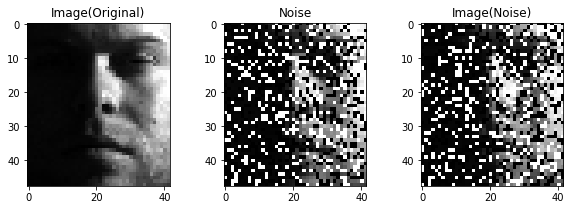

In [380]:
# Load dataset.
print('==> Load YaleB dataset ...')
V_hat_Ya, Y_hat_Ya = load_data('data/CroppedYaleB', reduce=4)
print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat_Ya.shape, Y_hat_Ya.shape))

# Add Noise.
#V_noise = np.random.rand(*V_hat.shape) * 40
#V = V_hat + V_noise
V_noise_Ya = s_p_noise(0.6,V_hat_Ya)
V_Ya= s_p_noise(0.6,V_hat_Ya)

# *********************************************************
# Norm_transform                                          #
V_hat_norm_Ya = norm(V_hat_Ya)                                  #
V_norm_Ya = norm(V_Ya)                                          #
#**********************************************************
# Plot result.
import matplotlib.pyplot as plt
img_size = [i//2 for i in (84, 96)] # YaleB
ind = 2 # index of demo image.
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(V_hat_Ya[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_noise_Ya[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Noise')
plt.subplot(133)
plt.imshow(V_Ya[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')
plt.show()

**2.1.2.1 Apply NMF algorithm**

In [319]:
print('==> Apply NMF ...')
# Compute W and H use NMF algorithm 1
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

RRE_total_ya = []
acc_total_ya = []
nmi_total_ya = []
for i in range(5):
    x, x_hat, y = sample(V_hat_norm_Ya, V_hat_norm_Ya, Y_hat_Ya)
    t0 = time.time()
    W, H = NMF_base_fit(x,k=38,n_iter = 5000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_ya.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H.T, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_ya.append(acc)
    nmi_total_ya.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))

print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_ya)))
print('RRE_average_std = {}'.format(np.std(RRE_total_ya)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_ya)))
print('ACC_average_std = {}'.format(np.std(acc_total_ya)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_ya)))
print('nmi_average_std = {}'.format(np.std(nmi_total_ya)))

==> Apply NMF ...
0 412.1164004166391
500 153.87014861362434
1000 152.36011697943874
1500 151.78307179648476
2000 151.49113569055166
Stop: 2397 151.34610007066723
W.shape=(2016, 38), H.shape=(38, 2172)
==> Evaluate RRE for NMF
RRE 1  = 0.19702191180980327
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.2385 (0.3027)
Runtime: 6.399 mins
0 411.519854118181
500 154.129447453423
1000 152.8875267070708
1500 152.38425084568286
2000 152.09372611537856
2500 151.88202161940168
Stop: 2916 151.74392647280015
W.shape=(2016, 38), H.shape=(38, 2172)
==> Evaluate RRE for NMF
RRE 2  = 0.1982533371150278
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.2343 (0.3239)
Runtime: 10.265 mins
0 412.4381905077675
500 154.93471346992487
1000 153.34770824853484
1500 152.7338978854767
2000 152.32829186482698
2500 152.01127368264073
3000 151.7914400926627
Stop: 3355 151.66526551140947
W.shape=(2016, 38), H.shape=(38, 2172)
==> Evaluate RRE for NMF
RRE 3  = 0.1969569932038647
==> Evaluate Acc and NMI ...
Acc(NMI) 3 = 0.252

**2.1.2.2 Apply $L_{2,1}$-Norm NMF**

In [325]:
print('==> Apply L21-Norm NMF')
RRE_total_l21_ya = []
acc_total_l21_ya = []
nmi_total_l21_ya = []
for i in range(3):
    x, x_hat, y = sample(V_hat_norm_Ya, V_hat_norm_Ya, Y_hat_Ya)
    t0 = time.time()
    W,H = NMF_L21_fit(x,k=38,max_iters = 5000)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for L21_NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_l21_ya.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H.T, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_l21_ya.append(acc)
    nmi_total_l21_ya.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))
    
    
print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_l21_ya)))
print('RRE_average_std = {}'.format(np.std(RRE_total_l21_ya)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_l21_ya)))
print('ACC_average_std = {}'.format(np.std(acc_total_l21_ya)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_l21_ya)))
print('nmi_average_std = {}'.format(np.std(nmi_total_l21_ya)))

==> Apply L21-Norm NMF
906185.913183722
0 18240.760894498897
500 6993.478782242828
1000 6925.430184204949
1500 6899.119985473451
2000 6883.866560641149
2500 6874.531511227016
Stop: 2585 6873.129803503715
W.shape=(2016, 38), H.shape=(38, 2172)
==> Evaluate RRE for L21_NMF
RRE 1  = 0.1982015908385617
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.2551 (0.3161)
Runtime: 49.670 mins
906119.5061773714
0 18122.57364212406
500 6981.777493171218
1000 6906.731338916535
1500 6881.435184448617
2000 6866.698708782126
2500 6857.764264847944
Stop: 2596 6856.353006576128
W.shape=(2016, 38), H.shape=(38, 2172)
==> Evaluate RRE for L21_NMF
RRE 2  = 0.1979737123357516
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.2486 (0.3190)
Runtime: 45.720 mins
906013.2175967782
0 18271.84390223777
500 7019.233257296326
1000 6950.643416476494
1500 6923.948265082599
2000 6909.41514545781
2500 6899.934133431973
Stop: 2624 6898.1559230093
W.shape=(2016, 38), H.shape=(38, 2172)
==> Evaluate RRE for L21_NMF
RRE 3  = 0.19820813

**2.1.2.3 Apply CIM-NMF**

In [381]:
print('==> Apply CIM NMF')
RRE_total_CIM_ya = []
acc_total_CIM_ya = []
nmi_total_CIM_ya = []
for i in range(3):
    x, x_hat, y = sample(V_hat_norm_Ya, V_hat_norm_Ya, Y_hat_Ya)
    t0 = time.time()
    W,H = NMF_L21_fit(x,k=40,max_iters = 6500)
    t1 = time.time()

    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE for CIM_NMF')
    RRE = np.linalg.norm(x_hat - W.dot(H)) / np.linalg.norm(x_hat)
    print('RRE {}  = {}'.format(i+1,RRE))
    RRE_total_CIM_ya.append(RRE)
    print('==> Evaluate Acc and NMI ...')
    Y_pred = assign_cluster_label(H.T, y)
    acc = accuracy_score(y, Y_pred)
    nmi = normalized_mutual_info_score(y, Y_pred)
    print('Acc(NMI) {} = {:.4f} ({:.4f})'.format(i+1, acc, nmi))
    acc_total_CIM_ya.append(acc)
    nmi_total_CIM_ya.append(nmi)
    print('Runtime: %.3f mins' % ((t1-t0)/60))
    
    
print('*'*50)   
print('RRE_average = {}'.format(np.mean(RRE_total_CIM_ya)))
print('RRE_average_std = {}'.format(np.std(RRE_total_CIM_ya)))
print('*'*50)
print('ACC_average = {}'.format(np.mean(acc_total_CIM_ya)))
print('ACC_average_std = {}'.format(np.std(acc_total_CIM_ya)))
print('*'*50)
print('nmi_average = {}'.format(np.mean(nmi_total_CIM_ya)))
print('nmi_average_std = {}'.format(np.std(nmi_total_CIM_ya)))

==> Apply CIM NMF
954698.6022143989
0 18100.278241043132
500 6883.040159373918
1000 6798.945996953398
1500 6773.377989750773
2000 6762.328459981922
2500 6755.966407616529
3000 6751.089853024127
Stop: 3328 6748.465368576668
W.shape=(2016, 40), H.shape=(40, 2172)
==> Evaluate RRE for CIM_NMF
RRE 1  = 0.19474555535186489
==> Evaluate Acc and NMI ...
Acc(NMI) 1 = 0.2652 (0.3431)
Runtime: 119.642 mins
954670.9860698264
0 18203.34428790007
500 6908.127124119259
1000 6834.461608634603
1500 6809.785464849532
2000 6796.58561134217
2500 6787.512436705707
3000 6780.241887335951
3500 6774.175719167011
4000 6768.77997597479
4500 6764.377812437758
Stop: 4651 6763.256273067507
W.shape=(2016, 40), H.shape=(40, 2172)
==> Evaluate RRE for CIM_NMF
RRE 2  = 0.19464752935303797
==> Evaluate Acc and NMI ...
Acc(NMI) 2 = 0.2684 (0.3274)
Runtime: 136.497 mins
954762.0062545552
0 18182.97397358788
500 6900.794619601584
1000 6829.038065597735
1500 6797.189826889815
2000 6778.086929613686
2500 6764.765198568817


### 2.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\} $$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [35]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

#print('==> Evaluate Acc and NMI ...')

# Assign cluster labels.
#Y_pred = assign_cluster_label(H.T, Y_hat)

#acc = accuracy_score(Y_hat, Y_pred)
#nmi = normalized_mutual_info_score(Y_hat, Y_pred)
#print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
